In [31]:
feat = ['flow_duration',
 'Header_Length',
 'Duration',
 'Rate',
 'ack_count',
 'syn_count',
 'fin_count',
 'urg_count',
 'HTTP',
 'ARP',
 'Min',
 'Max',
 'Tot size',
 'IAT',
 'Variance']

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
import time
from river import drift


In [20]:
df = pd.read_csv('F:\Projects\Cap_github\Capstone\Data\master_bin_data.csv')

In [21]:
df.columns = df.columns.str.replace(' ', '_')

In [22]:
df['label'] = df['label'].apply(lambda x: 0 if 'Benign' in str(x) else 1)

In [28]:
# Filter the dataset to include only the columns in the 'feat' list
X = df[feat]  # Assuming 'feat' is a list of column names
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.5, test_size=0.5, shuffle=True, random_state=0
)


In [24]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model,forest
from river.drift.binary import DDM, EDDM,HDDM_A,HDDM_W
import logging

In [25]:
#With drift of 80

def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = drift.binary.EDDM()
    
    # Learn the training set
    for xi1, yi1 in zip(X_train.values, y_train): 
        xi = dict(zip(X_train.columns, xi1))   
        model.learn_one(xi, yi1) 

    # Predict the test set and perform drift detection
    for x_val, y_val in zip(X_test.values, y_test):
        x = dict(zip(X_test.columns, x_val))
        y_pred = model.predict_one(x)  # Predict the test sample
        model.learn_one(x, y_val) # Learn the test sample
        metric.update(y_val, y_pred) # Update the real-time accuracy
        
        # Drift detection part
        val = 0
        
        if y_val != y_pred:
           val = 1 
           eddm.update(y_val)
        if eddm.drift_detected:
            print(f"Change detected at index {i}, input value: {y_val}")
            
           
        if eddm.warning_detected:
           print(f"Warning detected at index {i}")
        # Print samples every 80 iterations
        if i % 80 == 0:
            print(f"Sample {i}: True label: {y_val}, Predicted label: {y_pred}") 

        # Performance evaluation
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(y_val)
        yp.append(y_pred)
        i += 1

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp,average='macro'), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp,average='macro'), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp,average='macro'), 4) * 100) + "%")

    return t, m

In [26]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    #if m:  # Check if m is not empty
    plt.plot(t, m, '-b', label='Avg Accuracy: %.2f%%' % (m[-1]))

    #plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on IoTID20 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 1, Predicted label: 1
Sample 240: True label: 1, Predicted label: 1
Sample 320: True label: 0, Predicted label: 0
Sample 400: True label: 0, Predicted label: 0
Sample 480: True label: 1, Predicted label: 1
Sample 560: True label: 0, Predicted label: 0
Warning detected at index 565
Warning detected at index 566
Warning detected at index 567
Warning detected at index 568
Warning detected at index 569
Warning detected at index 570
Warning detected at index 571
Warning detected at index 572
Warning detected at index 573
Warning detected at index 574
Warning detected at index 575
Warning detected at index 576
Warning detected at index 577
Warning detected at index 578
Warning detected at index 579
Warning detected at index 580
Warning detected at index 581
Warning detected at index 582
Warning detected at index 583
Warning detected at index 584
Warning detected at index 585
Warni

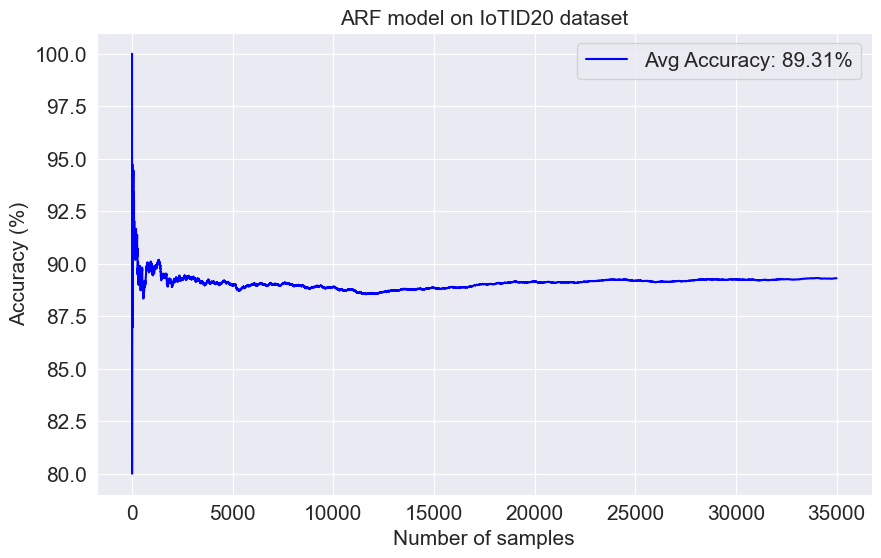

In [29]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model
name = "ARF model"
model = forest.ARFClassifier(n_models = 3,drift_detector=EDDM()) # Define the model
t, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

Sample 0: True label: 1, Predicted label: 0
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 1, Predicted label: 0
Warning detected at index 181
Warning detected at index 182
Warning detected at index 183
Warning detected at index 184
Warning detected at index 185
Warning detected at index 186
Warning detected at index 187
Warning detected at index 188
Warning detected at index 189
Warning detected at index 190
Warning detected at index 191
Warning detected at index 192
Warning detected at index 193
Warning detected at index 194
Sample 240: True label: 1, Predicted label: 1
Warning detected at index 264
Warning detected at index 265
Warning detected at index 266
Warning detected at index 267
Warning detected at index 268
Warning detected at index 269
Warning detected at index 270
Warning detected at index 271
Warning detected at index 272
Warning detected at index 273
Warning detected at index 274
Warning detected at index 275
Warning detected at index 276
Warning d

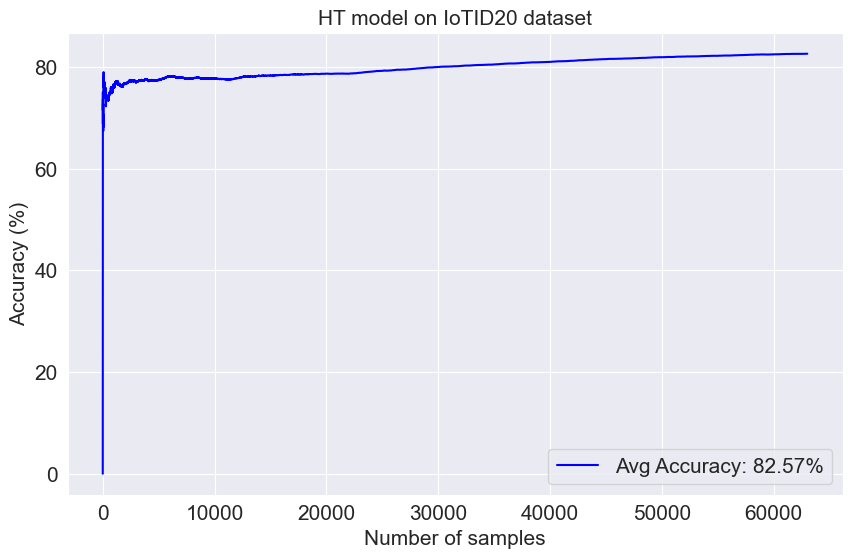

In [16]:
%%time
# Use the Hoeffding Tree (HT) model
name2 = "HT model"
model2 = tree.HoeffdingTreeClassifier()  # Define the model
t2, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test)  # Learn the model on the dataset
acc_fig(t2, m2, name2)  # Draw the figure of how the real-time accuracy changes with the number of samples


Accuracy: 83.91999999999999%
Precision: 83.94%
Recall: 83.91999999999999%
F1-score: 83.93%
CPU times: total: 6min 8s
Wall time: 6min 34s


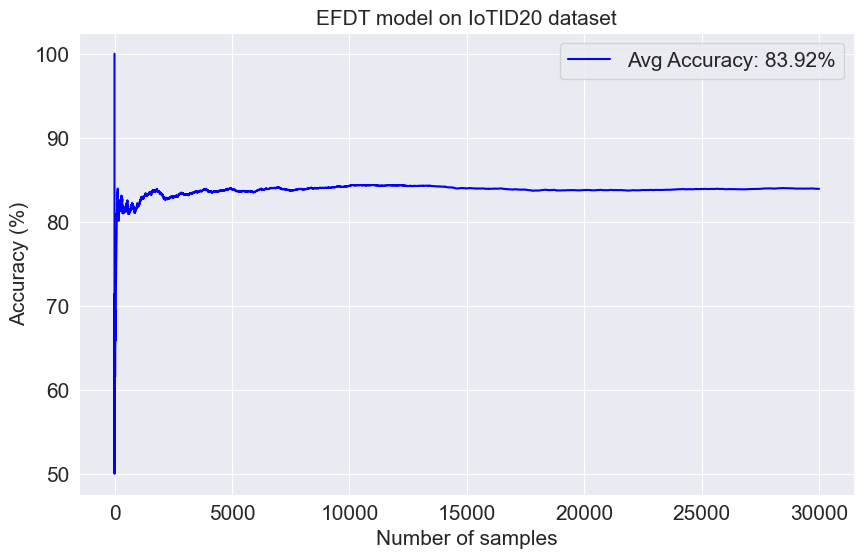

In [16]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model
name3 = "EFDT model"
model3 = tree.ExtremelyFastDecisionTreeClassifier()  # Define the model
logger3 = setup_logger("efdt_drift_detection.log")  # Set up logger for drift detection
t3, m3, logger3 = adaptive_learning(model3, X_train, y_train, X_test, y_test, logger=logger3)  # Learn the model on the dataset
acc_fig(t3, m3, name3)  # Draw the figure of how the real-time accuracy changes with the number of samples


Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 1, Predicted label: 1
Sample 240: True label: 1, Predicted label: 1
Sample 320: True label: 0, Predicted label: 0
Sample 400: True label: 0, Predicted label: 0
Warning detected at index 424
Warning detected at index 425
Warning detected at index 426
Warning detected at index 427
Warning detected at index 428
Warning detected at index 429
Warning detected at index 430
Warning detected at index 431
Warning detected at index 432
Warning detected at index 433
Warning detected at index 434
Warning detected at index 435
Warning detected at index 436
Warning detected at index 437
Change detected at index 438, input value: 1
Warning detected at index 438
Change detected at index 439, input value: 1
Warning detected at index 439
Change detected at index 440, input value: 0
Warning detected at index 440
Change detected at index 441, input value: 1
Warning detected at index 441
Change 

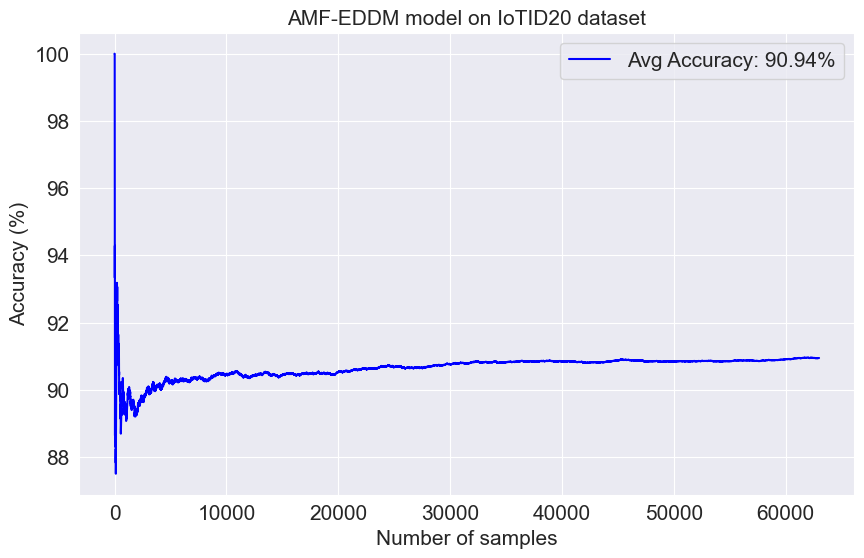

In [17]:
%%time
# Use the AMF-EDDM model
name4 = "AMF-EDDM model"
model4 = forest.AMFClassifier()  # Define the model
t4, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test)  # Learn the model on the dataset
acc_fig(t4, m4, name4)  # Draw the figure of how the real-time accuracy changes with the number of samples


Accuracy: 94.54%
Precision: 94.54%
Recall: 94.54%
F1-score: 94.54%
CPU times: total: 15min 54s
Wall time: 16min 33s


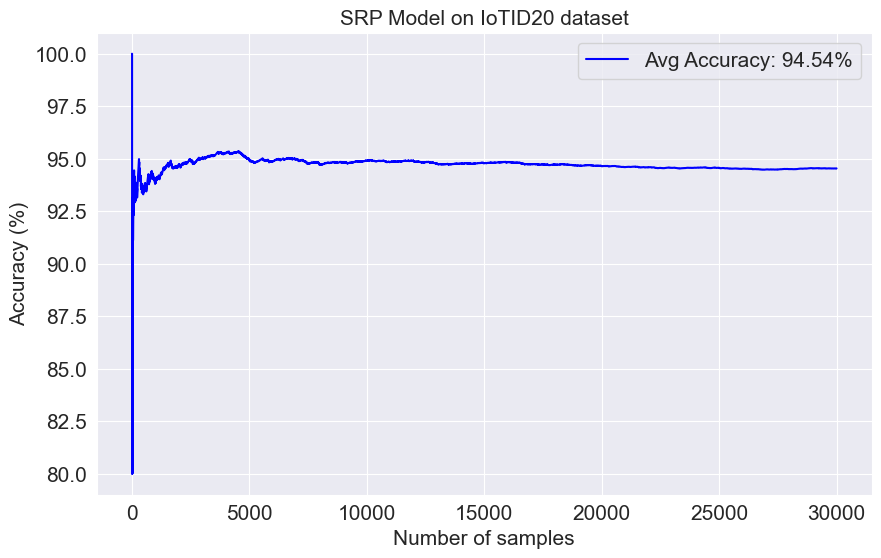

In [19]:
%%time
# Use the SRP Model
name5 = "SRP Model"
model5 = ensemble.SRPClassifier()  # Define the model
logger5 = setup_logger("srp_drift_detection.log")  # Set up logger for drift detection
t5, m5, logger5 = adaptive_learning(model5, X_train, y_train, X_test, y_test, logger=logger5)  # Learn the model on the dataset
acc_fig(t5, m5, name5)  # Draw the figure of how the real-time accuracy changes with the number of samples


Accuracy: 91.35%
Precision: 91.35%
Recall: 91.35%
F1-score: 91.35%
Time in seconds: 2665.4805483818054


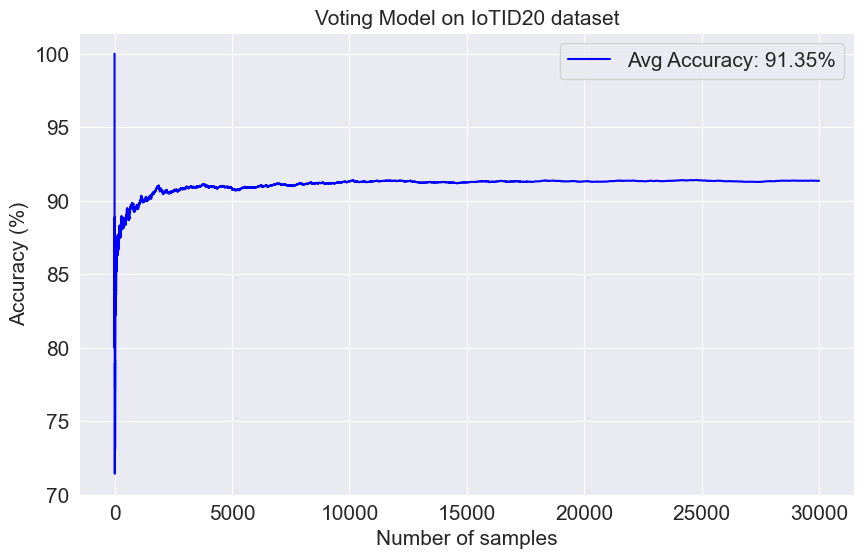

In [20]:
start = time.time()

# Use the Voting Classifier model
name10 = "Voting Model"
model10 = ensemble.VotingClassifier(
    [
        ensemble.SRPClassifier(),
        forest.AMFClassifier(),
        forest.ARFClassifier(),
        tree.ExtremelyFastDecisionTreeClassifier(),
        tree.HoeffdingAdaptiveTreeClassifier(),
        tree.HoeffdingTreeClassifier()
    ]
)

# Set up logger for drift detection
logger10 = setup_logger("voting_model_drift_detection.log")

# Learn the model on the dataset
t10, m10, logger10 = adaptive_learning(model10, X_train, y_train, X_test, y_test, logger=logger10)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t10, m10, name10)

end = time.time()
print("Time in seconds:", (end - start))


In [22]:
from river import preprocessing

In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.ExtremelyFastDecisionTreeClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingAdaptiveTreeClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingTreeClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.ARFClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.AMFClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.SRPClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingAdaptiveTreeClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingTreeClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.ARFClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.AMFClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.SRPClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name8 = "AdaBoost model"
model8 = ensemble.AdaBoostClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.SRPClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger9 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t8, m8, logger8 = adaptive_learning(model8, X_train, y_train, X_test, y_test, logger=logger8)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t8, m8, name8)
